Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score


loading the data

In [3]:
df=pd.read_csv('listings.csv')

In [4]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


Cannot see all the column names along with the data types it contains.

Lets see the percentage of nulls in each column

In [5]:
for i in df.columns:
    print(f"{i:<32}" +' %  Nulls: ' + f"{str(int((df[i].isnull().sum()/len(df))*100)) : >10}")

id                               %  Nulls:          0
listing_url                      %  Nulls:          0
scrape_id                        %  Nulls:          0
last_scraped                     %  Nulls:          0
name                             %  Nulls:          0
summary                          %  Nulls:          4
space                            %  Nulls:         14
description                      %  Nulls:          0
experiences_offered              %  Nulls:          0
neighborhood_overview            %  Nulls:         27
notes                            %  Nulls:         42
transit                          %  Nulls:         24
thumbnail_url                    %  Nulls:          8
medium_url                       %  Nulls:          8
picture_url                      %  Nulls:          0
xl_picture_url                   %  Nulls:          8
host_id                          %  Nulls:          0
host_url                         %  Nulls:          0
host_name                   

Many columns have data that provide no value and no value can be extracted through feature engineering.

Will do an initial drop and inspect the rest of the columns accordingly

In [6]:
df=df.drop(['listing_url','thumbnail_url','medium_url' , 'picture_url','xl_picture_url','scrape_id','last_scraped',
            'experiences_offered','picture_url','requires_license','license','jurisdiction_names','state','city','market'
            ,'smart_location','country_code','country','longitude','latitude','square_feet','has_availability',
            'calendar_last_scraped','host_url','host_name','host_location','host_about','host_thumbnail_url',
            'host_picture_url','street','availability_30','availability_60','availability_90','first_review',
            'last_review'],axis=1)

Lets look at the data types

In [7]:
for i in df.columns:
    print(f"{i:<32}" +'  : '+ str(df[i].dtypes))

id                                : int64
name                              : object
summary                           : object
space                             : object
description                       : object
neighborhood_overview             : object
notes                             : object
transit                           : object
host_id                           : int64
host_since                        : object
host_response_time                : object
host_response_rate                : object
host_acceptance_rate              : object
host_is_superhost                 : object
host_neighbourhood                : object
host_listings_count               : float64
host_total_listings_count         : float64
host_verifications                : object
host_has_profile_pic              : object
host_identity_verified            : object
neighbourhood                     : object
neighbourhood_cleansed            : object
neighbourhood_group_cleansed      : object
zipcode    

Many numerical columns are formated as objects, will need to change them to float for easier exploration

In [8]:
def numeric_converter(df):
    for i in df.columns:
        df[i]=df[i].str.strip('% $ ,')
        df[i]=df[i].str.replace(',', '')
        df[i]=pd.to_numeric(df[i],downcast='float')
    return df

df[['host_response_rate','price','security_deposit','cleaning_fee','weekly_price','monthly_price','extra_people']]=numeric_converter(df[['host_response_rate','price','security_deposit','cleaning_fee','weekly_price','monthly_price','extra_people']])



<ipython-input-8-d34566f29d80>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].str.strip('% $ ,')
<ipython-input-8-d34566f29d80>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].str.replace(',', '')
<ipython-input-8-d34566f29d80>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Instead of dropping the below columns directly, will try to see if there's a correlation between a positive language and the unit price

The below columns have no sentiment as per definition, so will check if the more a person describes the unit the higher the demand and therefore the price

In [9]:
cols=['notes','transit']

In [10]:
for i in cols:
    df[i]=df[i].str.len()

In [11]:
df_sent1=df[['id','name','summary','space','description']]

Filling the nulls with a neutral word because the sentiment analyzer does not work with nulls

In [12]:
df.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,host_id,host_since,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,956883,2011-08-11,...,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",1000.0,162.0,5177328,2013-02-21,...,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,155.0,202.0,16708587,2014-06-12,...,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,NaN,9851441,2013-11-06,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,9.0,295.0,1452570,2011-11-29,...,10.0,10.0,9.0,9.0,f,strict,f,f,1,0.89


In [13]:
df_sent1=df_sent1.fillna('none')

Defining a function and using it to replace each of the columns defined above in (df_sent1) with their sentiment value

There seem to be no correlation between any of the above columns and price

In [14]:
#plt.scatter(x=analyzed_df['description'],y=df['price']);
#analyzed_df['description'].corr(df['price'])

C:\Users\ajax2\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-15-dda7179e2eb7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['review_scores_total']=df1['review_scores_rating']+df1['review_scores_accuracy']+df1['review_scores_cleanliness']+df1.review_scores_checkin


-0.020269655985929252

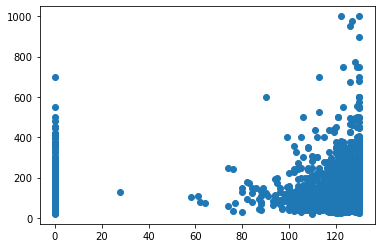

In [15]:
df1= df[['id', 'number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication','review_scores_value']]
df1.fillna(0,inplace=True)

df1['review_scores_total']=df1['review_scores_rating']+df1['review_scores_accuracy']+df1['review_scores_cleanliness']+df1.review_scores_checkin
+df1.review_scores_communication+df1.review_scores_value;

plt.scatter(x=df1['review_scores_total'],y=df['price']);
df1['review_scores_total'].corr(df['price'])

Drop the columns as they provide no value

In [16]:
df=df.drop(['name','summary','space','description','notes','transit','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication','review_scores_value','review_scores_location','neighborhood_overview'],axis=1)

Create a function that splits columns with multiple strings into separate columns and another function to count them

In [17]:
def str_split(df,col):
    
    df[col]=df[col].str.replace('"','')
    df[col]=df[col].str.strip(" []''")
    df=df[col].str.split(',',expand=True)
    
    return df

def row_count(df):    
    df['count']=df.apply(lambda x: x.count(), axis=1)
    return df

Use the above two functions on the Amenities column to check if there's a correlation between the number of amenities and price

In [18]:
df2=df[['amenities']]
df2

,amenities
0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
3,"{Internet,""Wireless Internet"",Kitchen,""Indoor ..."
4,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
...,...
3813,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
3814,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
3815,"{""Cable TV"",""Wireless Internet"",Kitchen,""Free ..."
3816,"{TV,""Wireless Internet"",Kitchen,""Free Parking ..."


In [19]:
str(df2['amenities'][0]).strip('{}').split(',')

['TV',
 '"Cable TV"',
 'Internet',
 '"Wireless Internet"',
 '"Air Conditioning"',
 'Kitchen',
 'Heating',
 '"Family/Kid Friendly"',
 'Washer',
 'Dryer']

In [20]:
def untangle(df):
    for j in range(len(df)):
        for i in str(df['amenities'][j]).strip('{}').split(','): 
            if i not in df.columns:
                df[i]=1
            else:
                df[i][j]=0
    return df
        

def labeler(x):
        if x==0:
            return 1
        else:
            return 0

In [21]:
df_amenities= untangle(df2).applymap(labeler)
df_amenities=df_amenities.drop(['amenities'],axis=1)

<ipython-input-20-1625c4be7d49>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=1
<ipython-input-20-1625c4be7d49>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][j]=0
<ipython-input-21-9f45c39b3b74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_amenities= untangle(df2).applymap(labeler)


In [22]:
df_amenities

,TV,"""Cable TV""",Internet,"""Wireless Internet""","""Air Conditioning""",Kitchen,Heating,"""Family/Kid Friendly""",Washer,Dryer,...,"""Elevator in Building""","""Lock on Bedroom Door""","""Wheelchair Accessible""",Gym,,Pool,"""Smoking Allowed""","""Other pet(s)""",Doorman,"""Washer / Dryer"""
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
3814,1,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3815,0,1,0,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3816,1,0,0,1,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [23]:
df_amenities.mean()

TV                              0.673913
"Cable TV"                      0.378470
Internet                        0.735987
"Wireless Internet"             0.960189
"Air Conditioning"              0.177056
Kitchen                         0.896281
Heating                         0.949712
"Family/Kid Friendly"           0.513882
Washer                          0.783394
Dryer                           0.784704
"Free Parking on Premises"      0.567313
"Buzzer/Wireless Intercom"      0.140650
"Smoke Detector"                0.859089
"Carbon Monoxide Detector"      0.650602
"First Aid Kit"                 0.439759
"Safety Card"                   0.190152
"Fire Extinguisher"             0.574908
Essentials                      0.847564
"Pets Allowed"                  0.123363
"Pets live on this property"    0.231011
Dog(s)                          0.133054
Cat(s)                          0.099790
"Hot Tub"                       0.079099
"Indoor Fireplace"              0.231797
Shampoo         

col_0,% observations
host_since,
2008-11-10,0.001048
2009-01-08,0.000262
2009-02-16,0.000524
2009-03-03,0.000262
2009-03-30,0.000262
...,...
2015-12-29,0.000262
2015-12-30,0.000262
2016-01-01,0.000262


# of unique values 1380


col_0,% observations
host_response_time,
a few days or more,0.011533
within a day,0.181184
within a few hours,0.293778
within an hour,0.513505


# of unique values 4


col_0,% observations
host_acceptance_rate,
0%,0.000328
100%,0.999672


# of unique values 2


col_0,% observations
host_is_superhost,
f,0.796122
t,0.203878


# of unique values 2


col_0,% observations
host_neighbourhood,
Alki,0.006254
Anaheim,0.001990
Arbor Heights,0.000853
Atlantic,0.013928
Baldwin Hills,0.000284
...,...
Wallingford,0.038090
Wedgewood,0.004548
Westlake,0.003411


# of unique values 102


col_0,% observations
host_verifications,
None,0.000524
"['email', 'facebook', 'google', 'linkedin', 'reviews', 'kba']",0.000262
"['email', 'facebook', 'reviews', 'jumio']",0.000786
"['email', 'facebook', 'reviews', 'kba']",0.000262
"['email', 'facebook', 'reviews']",0.000786
...,...
"['phone', 'reviews', 'kba']",0.000524
"['phone', 'reviews']",0.007858
['phone'],0.005238


# of unique values 116


col_0,% observations
host_has_profile_pic,
f,0.001834
t,0.998166


# of unique values 2


col_0,% observations
host_identity_verified,
f,0.214623
t,0.785377


# of unique values 2


col_0,% observations
neighbourhood,
Alki,0.006761
Arbor Heights,0.000882
Atlantic,0.014697
Ballard,0.062610
Belltown,0.059965
...,...
Wallingford,0.042034
Wedgewood,0.004409
Westlake,0.003527


# of unique values 81


col_0,% observations
neighbourhood_cleansed,
Adams,0.018334
Alki,0.011001
Arbor Heights,0.001310
Atlantic,0.013882
Belltown,0.061289
...,...
West Woodland,0.016763
Westlake,0.004453
Whittier Heights,0.006810


# of unique values 87


col_0,% observations
neighbourhood_group_cleansed,
Ballard,0.060241
Beacon Hill,0.030906
Capitol Hill,0.148507
Cascade,0.023311
Central Area,0.096647
Delridge,0.020691
Downtown,0.138816
Interbay,0.002881
Lake City,0.017548


# of unique values 17


col_0,% observations
zipcode,
98101,0.052742
98102,0.088953
98103,0.103385
98104,0.024928
98105,0.059040
98106,0.015219
98107,0.047232
98108,0.014694
98109,0.053004


# of unique values 28


col_0,% observations
is_location_exact,
f,0.106338
t,0.893662


# of unique values 2


col_0,% observations
property_type,
Apartment,0.447472
Bed & Breakfast,0.009693
Boat,0.002096
Bungalow,0.003406
Cabin,0.005502
Camper/RV,0.003406
Chalet,0.000524
Condominium,0.023841
Dorm,0.000524


# of unique values 16


col_0,% observations
room_type,
Entire home/apt,0.665532
Private room,0.303824
Shared room,0.030644


# of unique values 3


col_0,% observations
bed_type,
Airbed,0.007072
Couch,0.003405
Futon,0.019382
Pull-out Sofa,0.012310
Real Bed,0.957831


# of unique values 5


col_0,% observations
amenities,
"{""Air Conditioning"",Kitchen,""Free Parking on Premises"",""Pets Allowed"",Heating,Washer,Dryer,""Smoke Detector"",Essentials,Shampoo,""Lock on Bedroom Door"",Hangers}",0.000262
"{""Cable TV"",""Elevator in Building"",Heating,Washer,Dryer}",0.000262
"{""Cable TV"",""Wireless Internet"",""Air Conditioning"",""Free Parking on Premises"",Breakfast,""Pets live on this property"",Dog(s),""Indoor Fireplace"",Heating,Washer,Dryer,""Smoke Detector"",""Carbon Monoxide Detector"",""Fire Extinguisher"",Essentials,Shampoo}",0.000262
"{""Cable TV"",""Wireless Internet"",""Air Conditioning"",""Wheelchair Accessible"",Kitchen,""Free Parking on Premises"",""Pets Allowed"",Heating,""Family/Kid Friendly"",Washer,Dryer,""Smoke Detector"",""Carbon Monoxide Detector"",""First Aid Kit"",""Fire Extinguisher"",Essentials,""24-Hour Check-in"",Hangers,Iron,""Laptop Friendly Workspace""}",0.000262
"{""Cable TV"",""Wireless Internet"",""Air Conditioning"",Breakfast,""Pets live on this property"",Cat(s),Heating,""Smoke Detector"",""First Aid Kit"",Essentials,Shampoo,Hangers,""Hair Dryer""}",0.000262
...,...
"{TV,Kitchen,Heating,Washer,Dryer,""Smoke Detector"",""Carbon Monoxide Detector"",Essentials,Shampoo}",0.000262
"{TV,Pool,Kitchen,""Elevator in Building"",""Buzzer/Wireless Intercom"",Heating,Washer,Dryer,Essentials,Shampoo}",0.000262
"{TV,Pool,Kitchen,""Pets Allowed"",Gym,""Pets live on this property"",Dog(s),Cat(s),""Elevator in Building"",""Hot Tub"",""Indoor Fireplace"",Heating,""Family/Kid Friendly"",Washer,Dryer,Essentials,Hangers,Iron,""Laptop Friendly Workspace""}",0.000262


# of unique values 3284


col_0,% observations
calendar_updated,
1 week ago,0.006810
10 months ago,0.002095
11 months ago,0.001310
12 months ago,0.001310
13 months ago,0.000524
14 months ago,0.000262
15 months ago,0.000262
16 months ago,0.000262
17 months ago,0.000262


# of unique values 34


col_0,% observations
instant_bookable,
f,0.845207
t,0.154793


# of unique values 2


col_0,% observations
cancellation_policy,
flexible,0.301205
moderate,0.327658
strict,0.371137


# of unique values 3


col_0,% observations
require_guest_profile_picture,
f,0.915925
t,0.084075


# of unique values 2


col_0,% observations
require_guest_phone_verification,
f,0.901781
t,0.098219


# of unique values 2


,id,host_id,host_response_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,...,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3295.000000,3816.000000,3816.000000,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,...,1517.000000,1866.000000,2788.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3191.000000
mean,5.550111e+06,1.578556e+07,94.886795,7.157757,7.157757,3.349398,1.259469,1.307712,1.735394,127.976166,...,2613.336182,287.610382,61.710903,1.672603,10.667627,2.369303,780.447617,244.772656,2.946307,2.078919
std,2.962660e+06,1.458382e+07,11.866883,28.628149,28.628149,1.977599,0.590369,0.883395,1.139480,90.250107,...,1722.266724,270.222626,48.830311,1.311040,17.585938,16.305902,1683.589007,126.772526,5.893029,1.822348
min,3.335000e+03,4.193000e+03,17.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,20.000000,...,500.000000,95.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.020000
25%,3.258256e+06,3.275204e+06,98.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,75.000000,...,1512.000000,150.000000,25.000000,1.000000,0.000000,1.000000,60.000000,124.000000,1.000000,0.695000
50%,6.118244e+06,1.055814e+07,100.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,100.000000,...,2200.000000,250.000000,50.000000,1.000000,0.000000,2.000000,1125.000000,308.000000,1.000000,1.540000
75%,8.035127e+06,2.590309e+07,100.000000,3.000000,3.000000,4.000000,1.000000,2.000000,2.000000,150.000000,...,3150.000000,300.000000,83.000000,2.000000,20.000000,2.000000,1125.000000,360.000000,2.000000,3.000000
max,1.034016e+07,5.320861e+07,100.000000,502.000000,502.000000,16.000000,8.000000,7.000000,15.000000,1000.000000,...,19500.000000,5000.000000,300.000000,15.000000,300.000000,1000.000000,100000.000000,365.000000,37.000000,12.150000


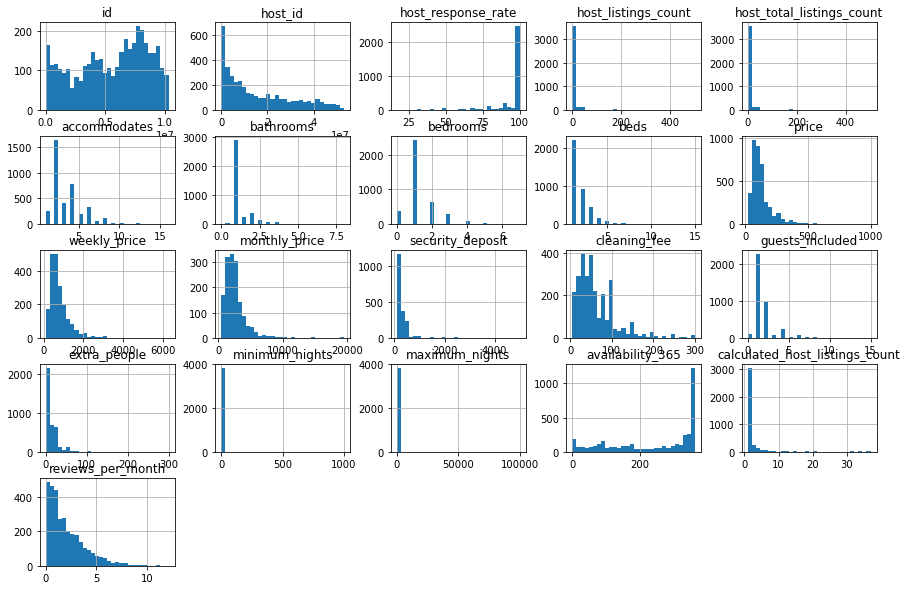

In [24]:
for column in df.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=df[column],
                        columns='% observations', 
                        normalize='columns'))
    print("# of unique values {}".format(df[column].nunique()))

# show summary statistics
display(df.describe())

# build histograms for each numeric feature
%matplotlib inline
hist = df.hist(bins=30, sharey=False, figsize=(15, 10))

In [25]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'availability_365', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

In [26]:
host_ver_df=df[['host_verifications']]

In [27]:
df_dummies=df[['host_response_time','host_is_superhost','host_identity_verified','neighbourhood_cleansed','zipcode',
      'is_location_exact','property_type','room_type','bed_type','instant_bookable','cancellation_policy',
       'require_guest_profile_picture','require_guest_phone_verification']]

In [28]:
df=df.drop(['host_since','host_acceptance_rate','host_neighbourhood','host_has_profile_pic','neighbourhood_group_cleansed',
      'neighbourhood','calendar_updated','host_response_rate'],axis=1)

In [29]:
df_numeric=df.select_dtypes(include=['int64','float64','float32','int32'])

df_numeric

,id,host_id,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,calculated_host_listings_count,reviews_per_month
0,241032,956883,3.0,3.0,4,1.0,1.0,1.0,85.0,NaN,NaN,NaN,NaN,2,5.0,1,365,346,2,4.07
1,953595,5177328,6.0,6.0,4,1.0,1.0,1.0,150.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,291,6,1.48
2,3308979,16708587,2.0,2.0,11,4.5,5.0,7.0,975.0,NaN,NaN,1000.0,300.0,10,25.0,4,30,220,2,1.15
3,7421966,9851441,1.0,1.0,3,1.0,0.0,2.0,100.0,650.0,2300.0,NaN,NaN,1,0.0,1,1125,143,1,NaN
4,278830,1452570,2.0,2.0,6,2.0,3.0,3.0,450.0,NaN,NaN,700.0,125.0,6,15.0,1,1125,365,1,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,31148752,354.0,354.0,6,2.0,3.0,3.0,359.0,NaN,NaN,NaN,230.0,1,0.0,3,1125,32,8,0.30
3814,8902327,46566046,1.0,1.0,4,1.0,1.0,2.0,79.0,NaN,NaN,500.0,50.0,3,25.0,2,29,273,1,2.00
3815,10267360,52791370,1.0,1.0,2,1.0,1.0,1.0,93.0,450.0,NaN,250.0,35.0,2,20.0,1,7,88,1,NaN
3816,9604740,25522052,1.0,1.0,2,1.0,0.0,1.0,99.0,NaN,NaN,300.0,45.0,1,0.0,3,1125,179,1,NaN


In [30]:
df.shape[1]-df_dummies.shape[1]-df_numeric.shape[1]

2

In [31]:
#df_dummies=pd.concat([df_dummies,df_amenities],axis=1)

In [32]:
df['host_verifications']=row_count(str_split(host_ver_df,'host_verifications'))[:]['count']

In [33]:
df_numeric=pd.concat([df_numeric,df['host_verifications']],axis=1)

In [34]:
df_numeric

,id,host_id,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,weekly_price,...,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,calculated_host_listings_count,reviews_per_month,host_verifications
0,241032,956883,3.0,3.0,4,1.0,1.0,1.0,85.0,NaN,...,NaN,NaN,2,5.0,1,365,346,2,4.07,4
1,953595,5177328,6.0,6.0,4,1.0,1.0,1.0,150.0,1000.0,...,100.0,40.0,1,0.0,2,90,291,6,1.48,6
2,3308979,16708587,2.0,2.0,11,4.5,5.0,7.0,975.0,NaN,...,1000.0,300.0,10,25.0,4,30,220,2,1.15,5
3,7421966,9851441,1.0,1.0,3,1.0,0.0,2.0,100.0,650.0,...,NaN,NaN,1,0.0,1,1125,143,1,NaN,5
4,278830,1452570,2.0,2.0,6,2.0,3.0,3.0,450.0,NaN,...,700.0,125.0,6,15.0,1,1125,365,1,0.89,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,31148752,354.0,354.0,6,2.0,3.0,3.0,359.0,NaN,...,NaN,230.0,1,0.0,3,1125,32,8,0.30,5
3814,8902327,46566046,1.0,1.0,4,1.0,1.0,2.0,79.0,NaN,...,500.0,50.0,3,25.0,2,29,273,1,2.00,5
3815,10267360,52791370,1.0,1.0,2,1.0,1.0,1.0,93.0,450.0,...,250.0,35.0,2,20.0,1,7,88,1,NaN,1
3816,9604740,25522052,1.0,1.0,2,1.0,0.0,1.0,99.0,NaN,...,300.0,45.0,1,0.0,3,1125,179,1,NaN,5


In [35]:
df.head()

,id,host_id,host_response_time,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,neighbourhood_cleansed,zipcode,...,extra_people,minimum_nights,maximum_nights,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,956883,within a few hours,f,3.0,3.0,4,t,West Queen Anne,98119,...,5.0,1,365,346,f,moderate,f,f,2,4.07
1,953595,5177328,within an hour,t,6.0,6.0,6,t,West Queen Anne,98119,...,0.0,2,90,291,f,strict,t,t,6,1.48
2,3308979,16708587,within a few hours,f,2.0,2.0,5,t,West Queen Anne,98119,...,25.0,4,30,220,f,strict,f,f,2,1.15
3,7421966,9851441,NaN,f,1.0,1.0,5,t,West Queen Anne,98119,...,0.0,1,1125,143,f,flexible,f,f,1,NaN
4,278830,1452570,within an hour,f,2.0,2.0,5,t,West Queen Anne,98119,...,15.0,1,1125,365,f,strict,f,f,1,0.89


In [36]:
for i in df_numeric.columns:
    print(f"{i:<32}" +'  : '+ str(df[i].dtypes))

id                                : int64
host_id                           : int64
host_listings_count               : float64
host_total_listings_count         : float64
accommodates                      : int64
bathrooms                         : float64
bedrooms                          : float64
beds                              : float64
price                             : float32
weekly_price                      : float32
monthly_price                     : float32
security_deposit                  : float32
cleaning_fee                      : float32
guests_included                   : int64
extra_people                      : float32
minimum_nights                    : int64
maximum_nights                    : int64
availability_365                  : int64
calculated_host_listings_count    : int64
reviews_per_month                 : float64
host_verifications                : int64


In [37]:
for i in df_dummies.columns:
    print(f"{i:<32}" +'  : '+ str(df_dummies[i].dtypes))

host_response_time                : object
host_is_superhost                 : object
host_identity_verified            : object
neighbourhood_cleansed            : object
zipcode                           : object
is_location_exact                 : object
property_type                     : object
room_type                         : object
bed_type                          : object
instant_bookable                  : object
cancellation_policy               : object
require_guest_profile_picture     : object
require_guest_phone_verification  : object


<AxesSubplot:>

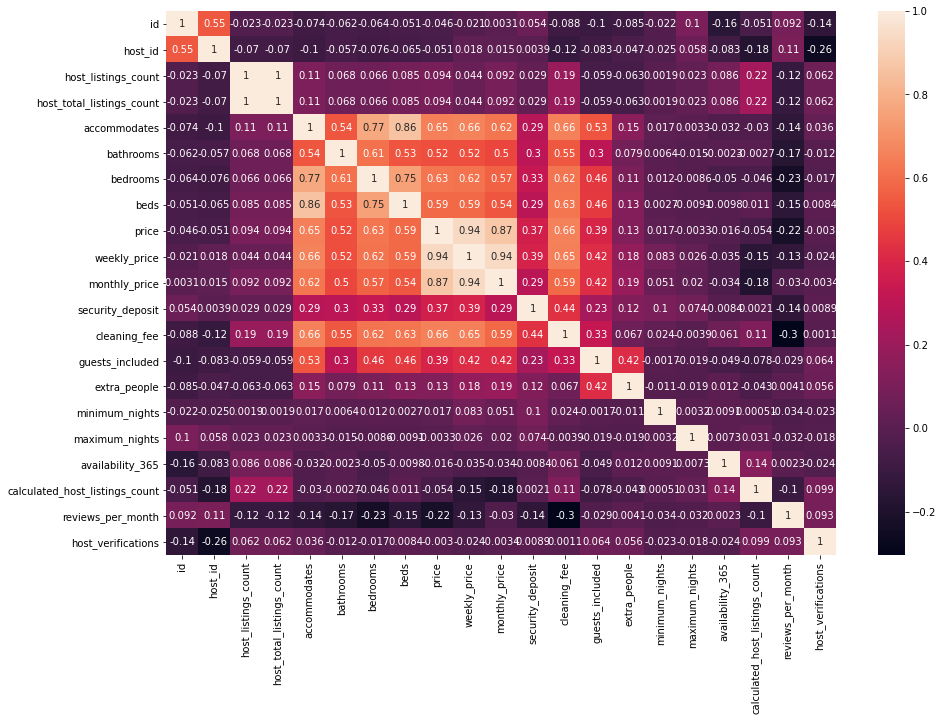

In [38]:
plt.figure(figsize = (15, 10))
sns.heatmap(df_numeric.corr(), annot=True)

In [39]:
df_numeric=df_numeric.drop(['id','host_id'],axis=1)

In [40]:
#df_numeric=df_numeric.drop(['id','host_id','availability_365', 'host_response_rate','host_listings_count','host_total_listings_count','calculated_host_listings_count','reviews_per_month'],axis=1)

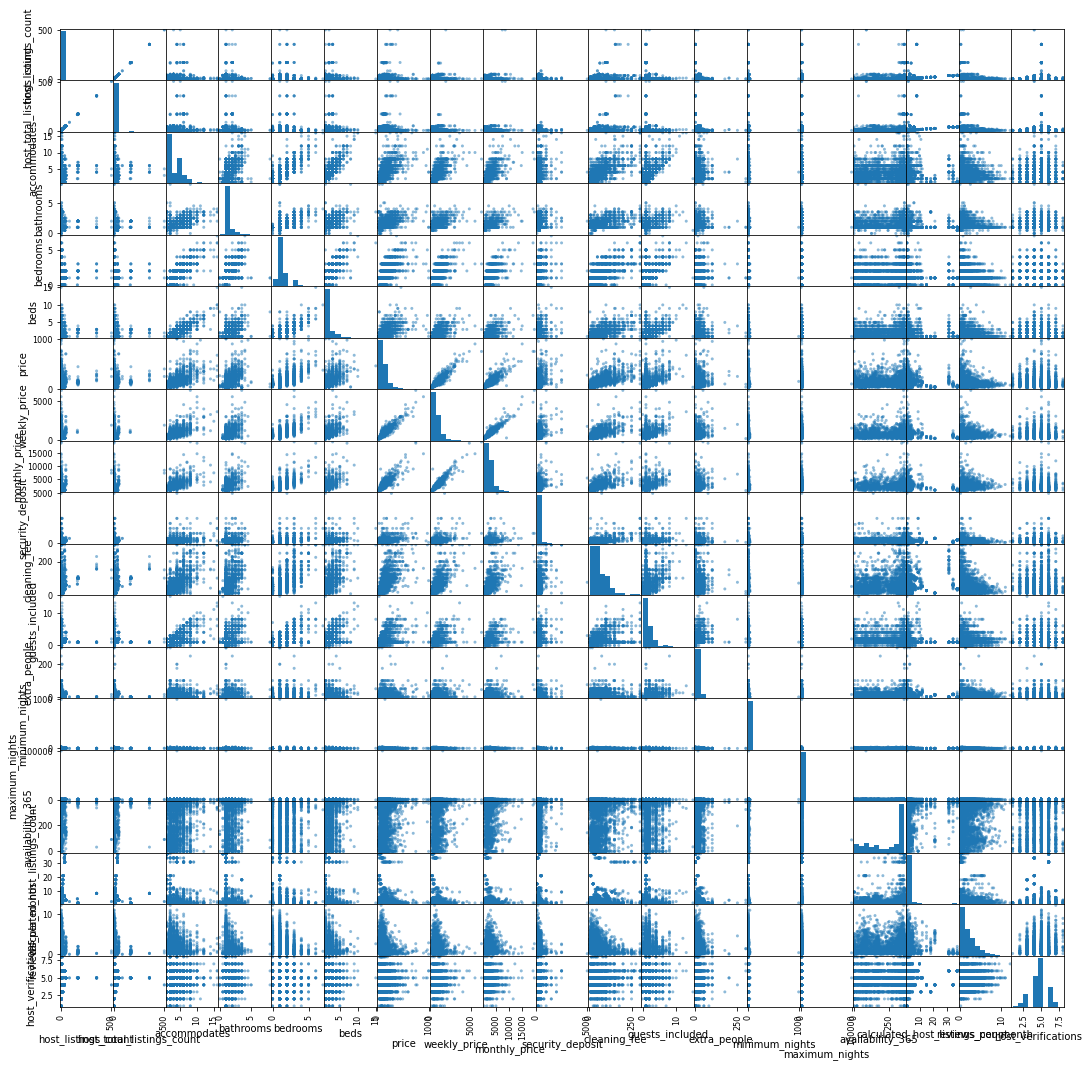

In [41]:
pd.plotting.scatter_matrix(df_numeric, figsize=(18,18));

<AxesSubplot:>

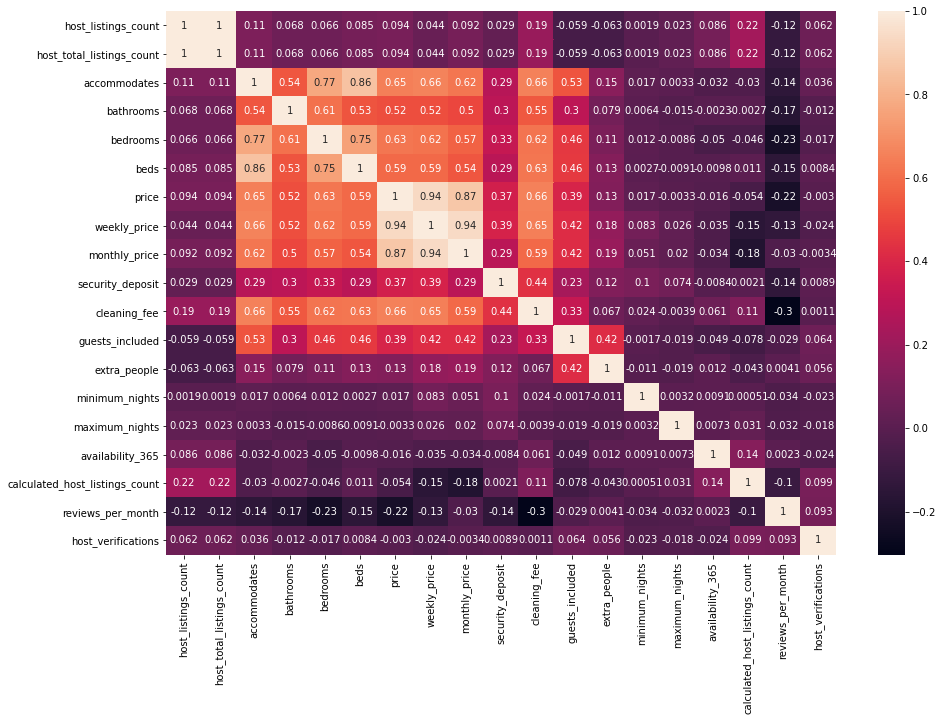

In [42]:
plt.figure(figsize = (15, 10))
sns.heatmap(df_numeric.corr(), annot=True)

In [43]:
y=df_numeric['price']
df_numeric=df_numeric.drop(['price'],axis=1)

In [44]:
for i in df_numeric.columns:
    print(f"{i:<32}" +' %  Nulls: ' + f"{str(int((df[i].isnull().sum()/len(df))*100)) : >10}")

host_listings_count              %  Nulls:          0
host_total_listings_count        %  Nulls:          0
accommodates                     %  Nulls:          0
bathrooms                        %  Nulls:          0
bedrooms                         %  Nulls:          0
beds                             %  Nulls:          0
weekly_price                     %  Nulls:         47
monthly_price                    %  Nulls:         60
security_deposit                 %  Nulls:         51
cleaning_fee                     %  Nulls:         26
guests_included                  %  Nulls:          0
extra_people                     %  Nulls:          0
minimum_nights                   %  Nulls:          0
maximum_nights                   %  Nulls:          0
availability_365                 %  Nulls:          0
calculated_host_listings_count   %  Nulls:          0
reviews_per_month                %  Nulls:         16
host_verifications               %  Nulls:          0


In [45]:
df_numeric.fillna(df_numeric.mean(),inplace=True)

In [46]:
df_numeric.weekly_price

0        788.481812
1       1000.000000
2        788.481812
3        650.000000
4        788.481812
           ...     
3813     788.481812
3814     788.481812
3815     450.000000
3816     788.481812
3817     788.481812
Name: weekly_price, Length: 3818, dtype: float32

In [80]:
df_numeric.shape[1]+df_dummies.shape[1]+df_amenities.shape[1]

73

In [81]:
def iterate1(df_numeric,df_dummies,df_amenities):
    score1=[]
    score2=[]
    for i in range(len(df_numeric.columns)):
        
        df1=df_numeric.iloc[:,i]
        if i==0: 
            df2=pd.concat([df_amenities,df1],axis=1)
            df3=df2
        elif i>0:
            df2=pd.concat([df2,df1],axis=1)
        
        X=df2
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

        lr=LinearRegression(normalize=True)

        lr.fit(X_train,y_train)

        y_pred=lr.predict(X_test)

        score1.append(r2_score(y_test,y_pred))
        
        if score1[i]>(score1[i-1]):
            df3=X
    
        
    for j in range(len(df_dummies.columns)):
        df1=pd.get_dummies(df_dummies.iloc[:,j],dummy_na=False)
        if j==0:
            df4=pd.concat([df3,df1],axis=1)
            df5=df4
        elif i>0:
            df4=pd.concat([df4,df1],axis=1)
        X=df4
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=40)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=40)

        lr=LinearRegression()

        lr.fit(X_train,y_train)

        y_pred=lr.predict(X_test)

        score2.append(r2_score(y_test,y_pred))
        
        if score1[i]>(score1[i-1]):
            df5=X
        
        
    return  df5



    

iterate1(df_numeric,df_dummies,df_amenities)


   

,TV,"""Cable TV""",Internet,"""Wireless Internet""","""Air Conditioning""",Kitchen,Heating,"""Family/Kid Friendly""",Washer,Dryer,...,extra_people,minimum_nights,maximum_nights,availability_365,calculated_host_listings_count,reviews_per_month,a few days or more,within a day,within a few hours,within an hour
0,0,0,0,0,0,0,0,0,0,0,...,5.0,1,365,346,2,4.070000,0,0,1,0
1,1,0,1,1,0,1,1,1,1,1,...,0.0,2,90,291,6,1.480000,0,0,0,1
2,1,1,1,1,1,1,1,1,1,1,...,25.0,4,30,220,2,1.150000,0,0,1,0
3,0,0,1,1,0,1,1,1,1,1,...,0.0,1,1125,143,1,2.078919,0,0,0,0
4,1,1,1,1,0,1,1,1,0,0,...,15.0,1,1125,365,1,0.890000,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,1,1,1,1,1,1,1,1,1,1,...,0.0,3,1125,32,8,0.300000,0,0,1,0
3814,1,1,1,1,0,1,1,1,0,0,...,25.0,2,29,273,1,2.000000,0,0,0,1
3815,0,1,0,1,0,1,1,0,1,1,...,20.0,1,7,88,1,2.078919,0,0,0,0
3816,1,0,0,1,0,1,1,0,0,0,...,0.0,3,1125,179,1,2.078919,0,0,0,1


In [68]:
def iterate2(df_numeric,df_dummies,df_amenities):
    score1=[]
    score2=[]
    for i in range(len(df_numeric.columns)):
        
        df1=df_numeric.iloc[:,i]
        if i==0: 
            df2=pd.concat([df_amenities,df1],axis=1)
            df3=df2
        elif i>0:
            df2=pd.concat([df2,df1],axis=1)
        
        X=df2
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

        lr=LinearRegression(normalize=True)

        lr.fit(X_train,y_train)

        y_pred=lr.predict(X_test)

        score1.append(r2_score(y_test,y_pred))
        
        if score1[i]>(score1[i-1]):
            df3=X
    
        
    for j in range(len(df_dummies.columns)):
        df1=pd.get_dummies(df_dummies.iloc[:,j],dummy_na=False)
        if j==0:
            df4=pd.concat([df3,df1],axis=1)
            df5=df4
        elif i>0:
            df4=pd.concat([df4,df1],axis=1)
        X=df4
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

        RF=RandomForestRegressor(n_estimators=300 , oob_score = True, n_jobs = -1,
                                  random_state =40, max_features = "auto",
                                  max_leaf_nodes = 500, max_depth=32, warm_start=True)

        RF.fit(X_train,y_train)

        y_pred_RF=RF.predict(X_test)

        r2_score(y_test,y_pred_RF)

        
        score2.append(r2_score(y_test,y_pred))
        
        if score1[i]>(score1[i-1]):
            df5=X
        
        
    return  df5



    

iterate2(df_numeric,df_dummies,df_amenities)

,TV,"""Cable TV""",Internet,"""Wireless Internet""","""Air Conditioning""",Kitchen,Heating,"""Family/Kid Friendly""",Washer,Dryer,...,extra_people,minimum_nights,maximum_nights,availability_365,calculated_host_listings_count,reviews_per_month,a few days or more,within a day,within a few hours,within an hour
0,0,0,0,0,0,0,0,0,0,0,...,5.0,1,365,346,2,4.070000,0,0,1,0
1,1,0,1,1,0,1,1,1,1,1,...,0.0,2,90,291,6,1.480000,0,0,0,1
2,1,1,1,1,1,1,1,1,1,1,...,25.0,4,30,220,2,1.150000,0,0,1,0
3,0,0,1,1,0,1,1,1,1,1,...,0.0,1,1125,143,1,2.078919,0,0,0,0
4,1,1,1,1,0,1,1,1,0,0,...,15.0,1,1125,365,1,0.890000,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,1,1,1,1,1,1,1,1,1,1,...,0.0,3,1125,32,8,0.300000,0,0,1,0
3814,1,1,1,1,0,1,1,1,0,0,...,25.0,2,29,273,1,2.000000,0,0,0,1
3815,0,1,0,1,0,1,1,0,1,1,...,20.0,1,7,88,1,2.078919,0,0,0,0
3816,1,0,0,1,0,1,1,0,0,0,...,0.0,3,1125,179,1,2.078919,0,0,0,1


In [82]:
X=iterate1(df_numeric,df_dummies,df_amenities)

In [83]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=40)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=40)

lr=LinearRegression()

lr.fit(X_train,y_train)

y_pred=lr.predict(X_test)

r2_score(y_test,y_pred)

0.672933524209187

In [84]:
RF=RandomForestRegressor(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =40, max_features = "auto",
                                  max_leaf_nodes = 600, max_depth=40, warm_start=True)

RF.fit(X_train,y_train)

y_pred_RF=RF.predict(X_test)

r2_score(y_test,y_pred_RF)

0.7050862275027591

In [85]:
y_pred_val=RF.predict(X_val)
r2_score(y_val,y_pred_val)

0.7473667174718334

In [ ]:
RF.get_params(deep=True)